### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import sys
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report


### Configuration

#### Constants

In [2]:
SEED=42
SOURCE_FILE = "../data_preprocessed/everything40_cleaned_normalized_reduced.csv"
VERBOSE = True

APPLY_SAMPLE_CUT_OFF = False
LIMIT_SAMPLES = 50 # sample cells
LIMIT_FEATURES = 500 # sample genes

np.random.seed(42) 

### Load dataset

In [3]:
%%time
dataset = pd.read_csv(SOURCE_FILE,index_col = 0)

if APPLY_SAMPLE_CUT_OFF:
    print("Applying cut off: ", LIMIT_SAMPLES, LIMIT_FEATURES)
    print("Before cut off: ", dataset.shape)
    dataset = dataset.iloc[0:LIMIT_SAMPLES, dataset.shape[1]-LIMIT_FEATURES:]
    print("After cut off: ", dataset.shape)

genes = dataset.shape[1] - 1
labels_count = dataset['Classification'].nunique()

CPU times: total: 141 ms
Wall time: 189 ms


In [4]:
print("Total samples: ", dataset.shape[0])
print("Total genes  : ", dataset.shape[1] - 1)
print("Total classes: ", labels_count)

Total samples:  4679
Total genes  :  138
Total classes:  75


In [5]:
X = dataset.iloc[:, :-1]
Y = dataset.iloc[:, -1]

print(X.shape)
print(Y.shape)

(4679, 138)
(4679,)


### Label encoding

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y) # labels to indices
y_categorical = to_categorical(y_encoded, num_classes=labels_count) # indices to 1 hot vectors
label_encoder.classes_

array(['Astro L1-2 FGFR3 GFAP', 'Astro L1-6 FGFR3 SLC14A1',
       'Endo L2-6 NOSTRIN', 'Exc L2 LAMP5 LTK',
       'Exc L2-3 LINC00507 FREM3', 'Exc L2-4 LINC00507 GLP2R',
       'Exc L3-4 RORB CARM1P1', 'Exc L3-5 RORB COL22A1',
       'Exc L3-5 RORB ESR1', 'Exc L3-5 RORB FILIP1L',
       'Exc L3-5 RORB TWIST2', 'Exc L4-5 FEZF2 SCN4B',
       'Exc L4-5 RORB DAPK2', 'Exc L4-5 RORB FOLH1B',
       'Exc L4-6 FEZF2 IL26', 'Exc L4-6 RORB C1R', 'Exc L4-6 RORB SEMA3E',
       'Exc L5-6 FEZF2 ABO', 'Exc L5-6 FEZF2 EFTUD1P1',
       'Exc L5-6 RORB TTC12', 'Exc L5-6 SLC17A7 IL15',
       'Exc L5-6 THEMIS C1QL3', 'Exc L5-6 THEMIS CRABP1',
       'Exc L5-6 THEMIS DCSTAMP', 'Exc L5-6 THEMIS FGF10',
       'Exc L6 FEZF2 OR2T8', 'Exc L6 FEZF2 SCUBE1', 'Inh L1 SST CHRNA4',
       'Inh L1 SST NMBR', 'Inh L1-2 GAD1 MC4R', 'Inh L1-2 LAMP5 DBP',
       'Inh L1-2 PAX6 CDH12', 'Inh L1-2 PAX6 TNFAIP8L3',
       'Inh L1-2 SST BAGE2', 'Inh L1-2 VIP LBH', 'Inh L1-2 VIP PCDH20',
       'Inh L1-2 VIP TSPAN12', 'In

### Create test, train splits datasets

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=SEED)

In [8]:
print("Original dataset: ", X.shape[0],"cells with", X.shape[1], "genes per cell")
print("Training   with : ", x_train.shape[0],"cells with", x_train.shape[1], "genes per cell")
print("Validating with : ", x_test.shape[0],"cells with", x_test.shape[1], "genes per cell")

Original dataset:  4679 cells with 138 genes per cell
Training   with :  3743 cells with 138 genes per cell
Validating with :  936 cells with 138 genes per cell


### Create the neural network

In [9]:
def CreateNeuralNetwork(genes, classes, layers, neurons_per_layer, drop_out = 0.2, activ = "relu", learning_rate=0.001, verbose = False):
    model = tf.keras.Sequential()   

    model.add(Input(shape=(genes,))) 

    for i in range(layers):
        model.add(Dense(neurons_per_layer, activation = activ))
        model.add(Dropout(drop_out))

    model.add(Dense(classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])

    if verbose:
        print(model.summary())

    return model

# epochs = 100
# model = CreateNeuralNetwork(genes, labels_count, 3, 100, 0.2)
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)
# history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), callbacks=callback)
# train_accuracy = history.history['accuracy'][-1]
# val_accuracy = history.history['val_accuracy'][-1]
# print(train_accuracy)
# print(val_accuracy)
# best_model = model


### Hyperparameter tuning

In [10]:
set_epochs = [ 100 ]
set_layers = [ 3, 6, 12 ]
set_neurons_per_layer = [100, 200, 300]
set_drop_out = [ 0.1 ]
set_activ = ["relu", "sigmoid"]
set_learning_rate = [0.0001]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

best_accuracy = None
best_model = None
best_history = None

i = 0
for epochs in set_epochs:
    for layers in set_layers:
        for neurons_per_layer in set_neurons_per_layer:
            for drop_out in set_drop_out:
                for f in set_activ:
                    for lr in set_learning_rate:
                        print("Examining case: ", i, layers, neurons_per_layer, drop_out, f, lr)
                        model = CreateNeuralNetwork(genes, labels_count, layers, neurons_per_layer, drop_out, f, lr, False)

                        history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), callbacks=callback)

                        # train_accuracy = history.history['accuracy'][-1]
                        val_accuracy = history.history['val_accuracy'][-1]

                        if best_model == None or val_accuracy > best_accuracy:
                            best_model = model
                            best_accuracy = val_accuracy
                            best_history = history

                        i=i+1

print("Best model")
print(best_model)

Examining case:  0 3 100 0.1 relu 0.0001
Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0618 - loss: 5.5085 - val_accuracy: 0.2521 - val_loss: 3.4299
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2370 - loss: 3.5604 - val_accuracy: 0.4850 - val_loss: 2.5424
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4087 - loss: 2.7594 - val_accuracy: 0.5876 - val_loss: 2.0222
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5150 - loss: 2.2525 - val_accuracy: 0.6538 - val_loss: 1.6534
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5781 - loss: 1.9142 - val_accuracy: 0.6880 - val_loss: 1.4055
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6240 - loss: 1.6548 - val_accuracy: 0.7276 - val_loss: 1.2157
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6672 - loss: 1.4348 - val_accuracy: 0.7511 - val_loss: 1.0688
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - a

Evaluate the best model:

In [11]:
loss, accuracy = best_model.evaluate(x_test, y_test)

print(loss)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9161 - loss: 0.2551
0.24446527659893036


Save to disk:

In [12]:
best_model.save("../models/nn.h5")

Calculate precision & recall:

In [13]:
predictions = np.argmax(best_model.predict(x_test), axis=-1)

y_test_labels = np.argmax(y_test, axis=1) # One hot vextors to labels

print(classification_report(y_test_labels, predictions, labels=np.arange(labels_count), target_names=label_encoder.classes_))

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                          precision    recall  f1-score   support

   Astro L1-2 FGFR3 GFAP       1.00      1.00      1.00         3
Astro L1-6 FGFR3 SLC14A1       1.00      1.00      1.00        11
       Endo L2-6 NOSTRIN       0.00      0.00      0.00         0
        Exc L2 LAMP5 LTK       0.83      0.91      0.87        47
Exc L2-3 LINC00507 FREM3       0.94      0.93      0.94       125
Exc L2-4 LINC00507 GLP2R       0.92      0.85      0.88        13
   Exc L3-4 RORB CARM1P1       0.94      0.89      0.91        18
   Exc L3-5 RORB COL22A1       0.90      0.90      0.90        10
      Exc L3-5 RORB ESR1       0.99      1.00      0.99        89
   Exc L3-5 RORB FILIP1L       0.82      0.82      0.82        17
    Exc L3-5 RORB TWIST2       1.00      0.33      0.50         3
    Exc L4-5 FEZF2 SCN4B       0.00      0.00      0.00         1
     Exc L4-5 RORB DAPK2       1.00      0.85      0.92        13
    Exc L4-5 RORB FOLH1B       1.00 

c:\Users\maria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maria\anaconda3\Lib\site-packages\sklearn\metrics\_cla

(0.0, 1.5)

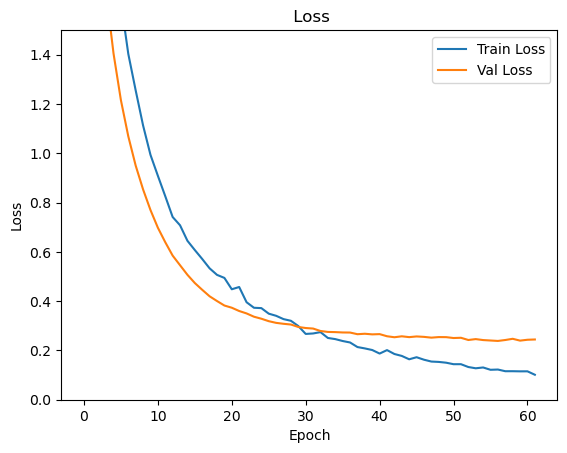

In [14]:
ax = plt.figure().gca()
plt.plot(best_history.history['loss'], label="Train Loss")
plt.plot(best_history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(" Loss")
plt.legend(loc="best")
plt.ylim(0, 1.5)

In [15]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │        13,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │         7,575 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,027 (488.39 KB)

 Trainable params: 41,675 (162.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 83,352 (325.60 KB)